In [12]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

from models.lstm import LSTMRegressor
from utils.stock_data import get_data_loaders, StockIndex
from utils.early_stopping import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [13]:
window_size = 7
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

BEST_LSTM_PARAMS = {
    StockIndex.NVDA: {
        "hidden_dim": 352,
        "num_layers": 1,
        "dropout": 0.28541614143129757,
        "batch_size": 16,
        "lr": 0.00044517259602202056
    },
    StockIndex.AAPL: {
        "hidden_dim": 384,
        "num_layers": 1,
        "dropout": 0.22917171281782978,
        "batch_size": 16,
        "lr": 0.0026358901455780454
    },
    StockIndex.KO: {
        "hidden_dim": 480,
        "num_layers": 1,
        "dropout": 0.19466720673124002,
        "batch_size": 16,
        "lr": 0.0014651429936464527
    }
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Training Baseline LSTM for each stock ##


### NVIDIA ###

In [14]:
stock = StockIndex.NVDA
lstm_params = BEST_LSTM_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                     use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.0046867606827737576
Epoch 2: Train=0.00030178807278527086
Epoch 3: Train=0.00020938115792685293
Epoch 4: Train=0.000208863242108356
Epoch 5: Train=0.00020228231351027698
Epoch 6: Train=0.0002061770809623248
Epoch 7: Train=0.00023588919172808998
Epoch 8: Train=0.00019547458267503187
Epoch 9: Train=0.000195022168499594
Epoch 10: Train=0.0002153657755612089
Epoch 11: Train=0.00016947197644810212
Epoch 12: Train=0.00017969873762481393
Epoch 13: Train=0.0001533570114983689
Epoch 14: Train=0.00022677862484624253
Epoch 15: Train=0.00018088268537975075
Epoch 16: Train=0.0001521327273134963
Epoch 17: Train=0.0001761152500628007
Epoch 18: Train=0.00015747576415176608
Epoch 19: Train=0.00015329888501215428
Epoch 20: Train=0.00015497878380163897
Epoch 21: Train=0.00015670000610760215
Epoch 22: Train=0.00013982346127254506
Epoch 23: Train=0.00012379432811223634
Epoch 24: Train=0.0001811272594189939
Epoch 25: Train=0.00016334449673645348
Epoch 26: Train=0.00012229145477708745
Epoch 

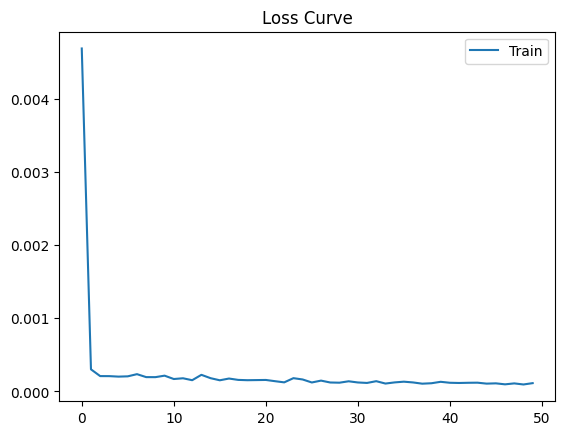

In [15]:
nvda_model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam(nvda_model.parameters(), lr=lstm_params['lr'])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    nvda_model.train()
    train_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(nvda_model(xb).squeeze(), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")# Val={val_loss}")

plt.plot(train_losses, label='Train')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 5.4897
Test MAE : 4.5313


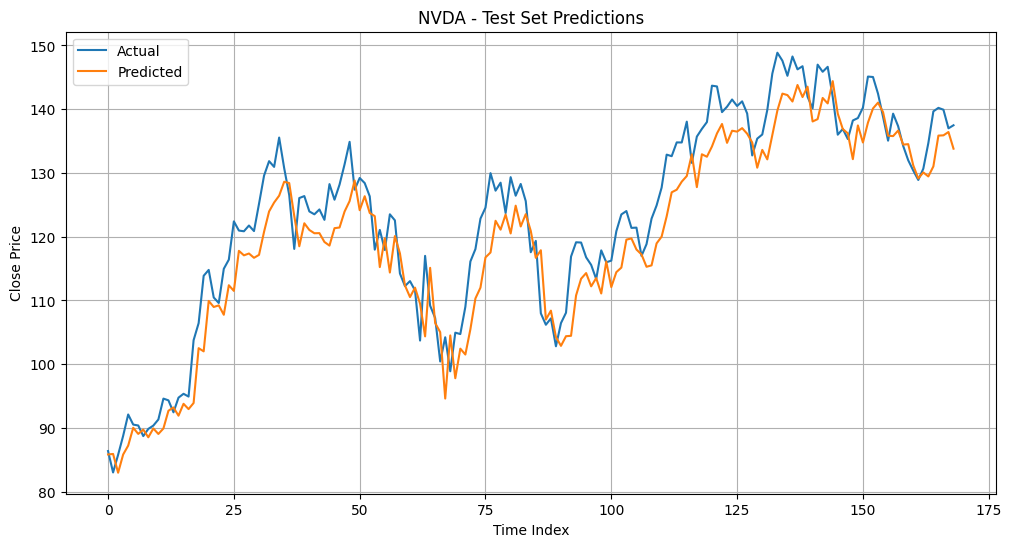

Actual Volatility (std of returns): 0.0328
Predicted Volatility             : 0.0301


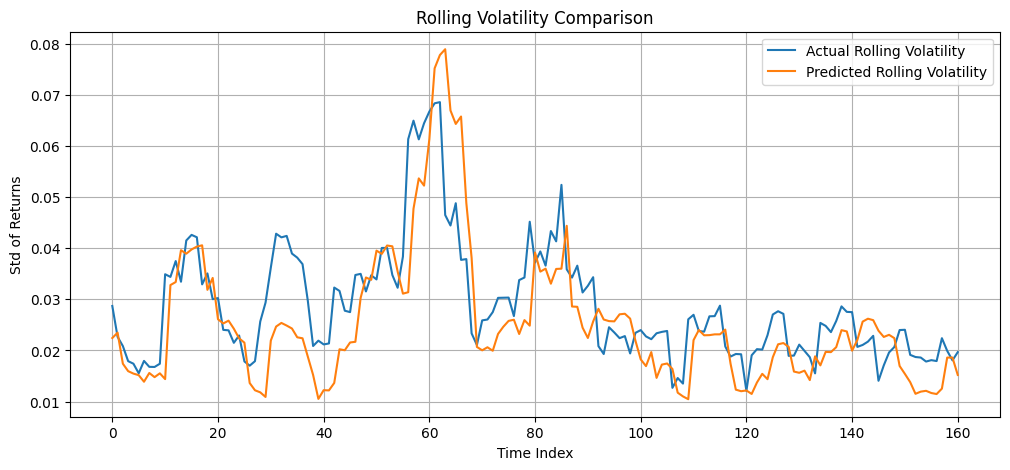

In [16]:
# Evaluate on test set
nvda_model.eval()
preds, targets = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        pred = nvda_model(xb).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
nvda_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
nvda_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(nvda_targets_unscaled, nvda_preds_unscaled))
mae = mean_absolute_error(nvda_targets_unscaled, nvda_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(nvda_targets_unscaled, label="Actual")
plt.plot(nvda_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(nvda_targets_unscaled) / nvda_targets_unscaled[:-1]
pred_returns   = np.diff(nvda_preds_unscaled) / nvda_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()


### APPLE ###

In [17]:
stock = StockIndex.AAPL
lstm_params = BEST_LSTM_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                     use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.010771318944700231
Epoch 2: Train=0.0005098383266930327
Epoch 3: Train=0.0004221631785148562
Epoch 4: Train=0.00043681176009498576
Epoch 5: Train=0.0004438526584176497
Epoch 6: Train=0.0003721379416858345
Epoch 7: Train=0.00039785857627819754
Epoch 8: Train=0.00037291271593233553
Epoch 9: Train=0.000517654396132613
Epoch 10: Train=0.0004909980876490032
Epoch 11: Train=0.0003853555976864741
Epoch 12: Train=0.0003878385030824428
Epoch 13: Train=0.0003144255841640059
Epoch 14: Train=0.00032667321537508434
Epoch 15: Train=0.00027115002718126175
Epoch 16: Train=0.0003169072929589252
Epoch 17: Train=0.00025789996553529903
Epoch 18: Train=0.0002688720927872422
Epoch 19: Train=0.0003120671023468891
Epoch 20: Train=0.000272928877919442
Epoch 21: Train=0.00029109723493662623
Epoch 22: Train=0.0002914951445277301
Epoch 23: Train=0.0002936969279409198
Epoch 24: Train=0.00025869445428293377
Epoch 25: Train=0.00025796147269600145
Epoch 26: Train=0.000284443794953404
Epoch 27: Train=

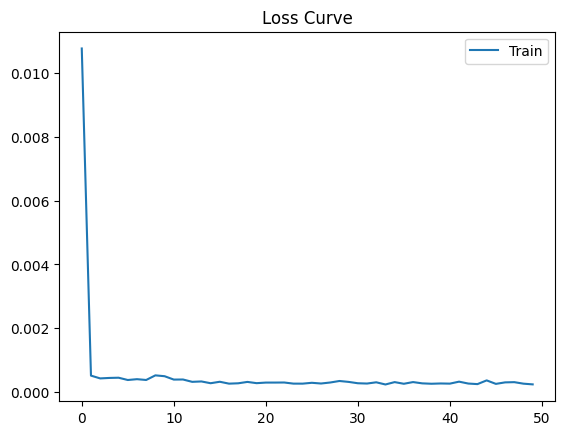

In [18]:
aapl_model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam(aapl_model.parameters(), lr=lstm_params['lr'])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    aapl_model.train()
    train_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(aapl_model(xb).squeeze(), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")# Val={val_loss}")

plt.plot(train_losses, label='Train')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 4.1709
Test MAE : 3.4498


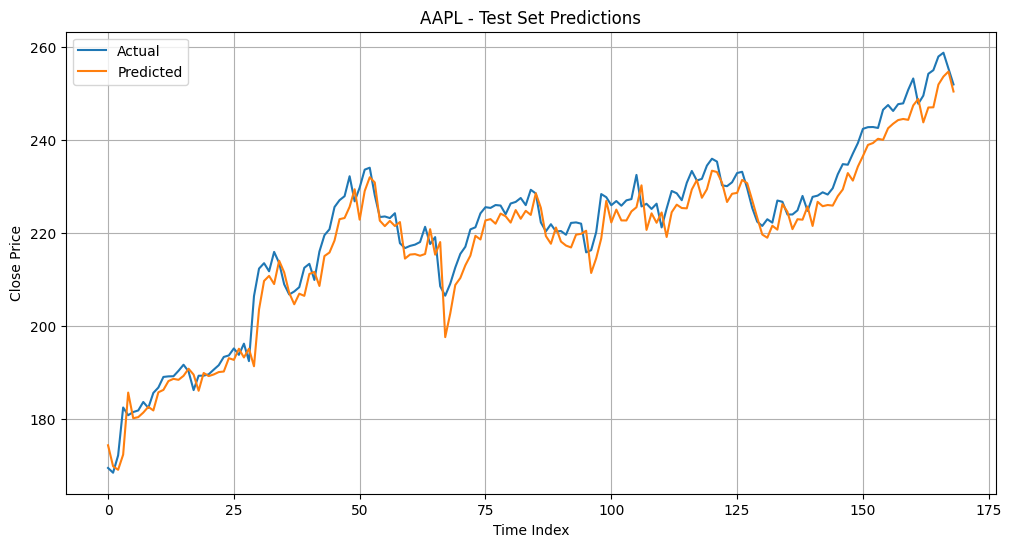

Actual Volatility (std of returns): 0.0145
Predicted Volatility             : 0.0179


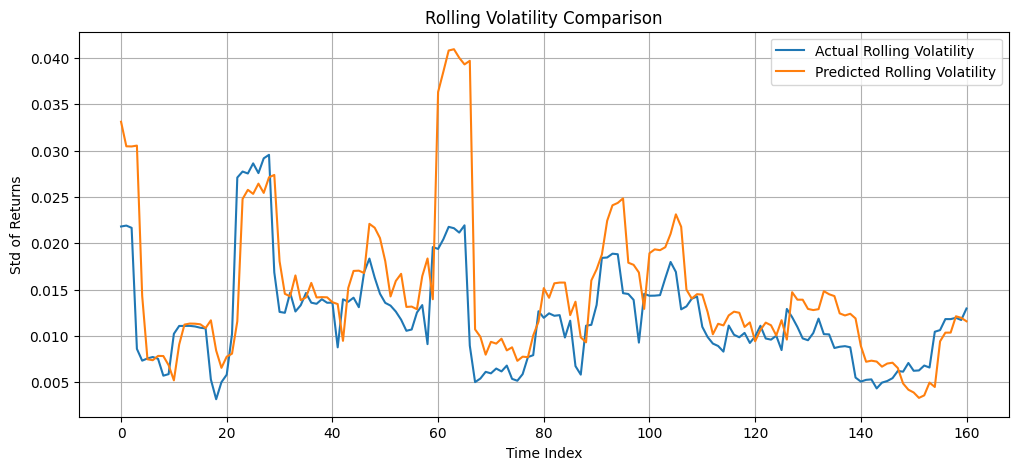

In [19]:
# Evaluate on test set
aapl_model.eval()
preds, targets = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        pred = aapl_model(xb).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
aapl_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
aapl_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(aapl_targets_unscaled, aapl_preds_unscaled))
mae = mean_absolute_error(aapl_targets_unscaled, aapl_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(aapl_targets_unscaled, label="Actual")
plt.plot(aapl_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(aapl_targets_unscaled) / aapl_targets_unscaled[:-1]
pred_returns   = np.diff(aapl_preds_unscaled) / aapl_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

### COKE ###

In [20]:
stock = StockIndex.KO
lstm_params = BEST_LSTM_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                              use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.013222554148847444
Epoch 2: Train=0.0011556393869933813
Epoch 3: Train=0.001176110502318338
Epoch 4: Train=0.0009880185470036748
Epoch 5: Train=0.000974968098682549
Epoch 6: Train=0.0009086675191712049
Epoch 7: Train=0.0009581229937288703
Epoch 8: Train=0.0008669235068020608
Epoch 9: Train=0.0007653128610914479
Epoch 10: Train=0.0006995539919113402
Epoch 11: Train=0.0006799391644884541
Epoch 12: Train=0.0006044726021237427
Epoch 13: Train=0.0006102640835881102
Epoch 14: Train=0.0006397277072090844
Epoch 15: Train=0.000573800725631905
Epoch 16: Train=0.0007451420096913353
Epoch 17: Train=0.0005241939614996116
Epoch 18: Train=0.0005794270692429637
Epoch 19: Train=0.0005043240418690586
Epoch 20: Train=0.0006304042683702639
Epoch 21: Train=0.0005085707679326232
Epoch 22: Train=0.0005136803934653996
Epoch 23: Train=0.0004789568178092289
Epoch 24: Train=0.0005230797598617048
Epoch 25: Train=0.0005610913899315596
Epoch 26: Train=0.0005346312378109856
Epoch 27: Train=0.0004974

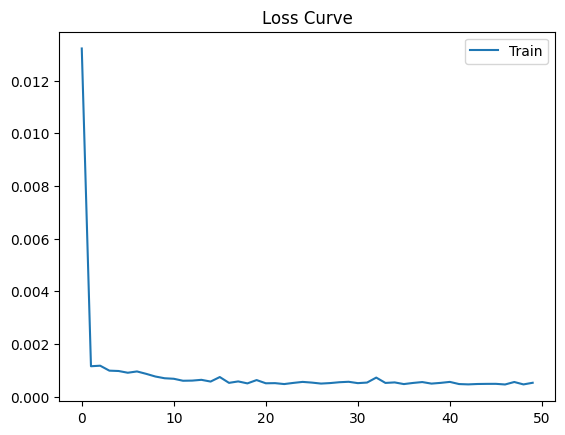

In [21]:
ko_model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam(ko_model.parameters(), lr=lstm_params['lr'])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    aapl_model.train()
    train_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(ko_model(xb).squeeze(), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")# Val={val_loss}")

plt.plot(train_losses, label='Train')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 1.2277
Test MAE : 1.0761


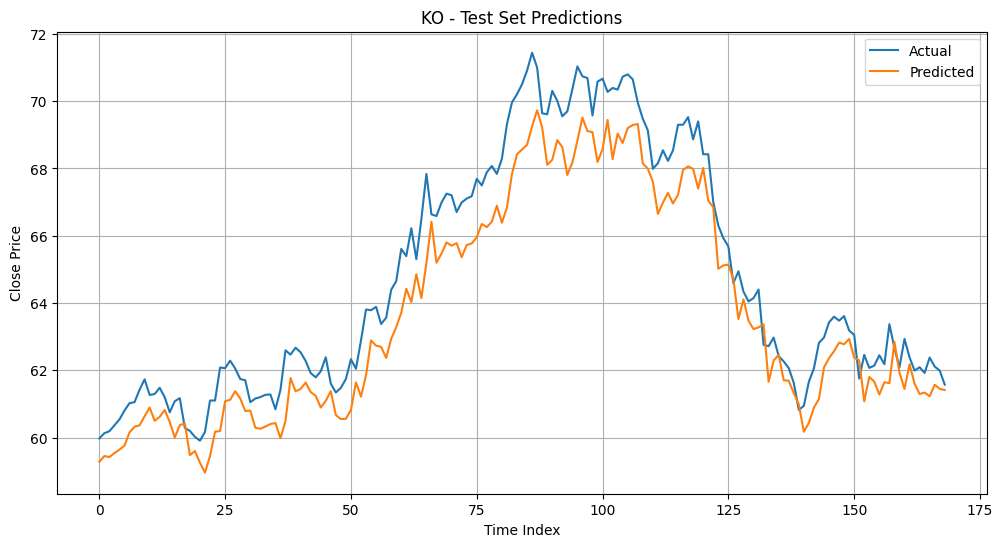

Actual Volatility (std of returns): 0.0083
Predicted Volatility             : 0.0086


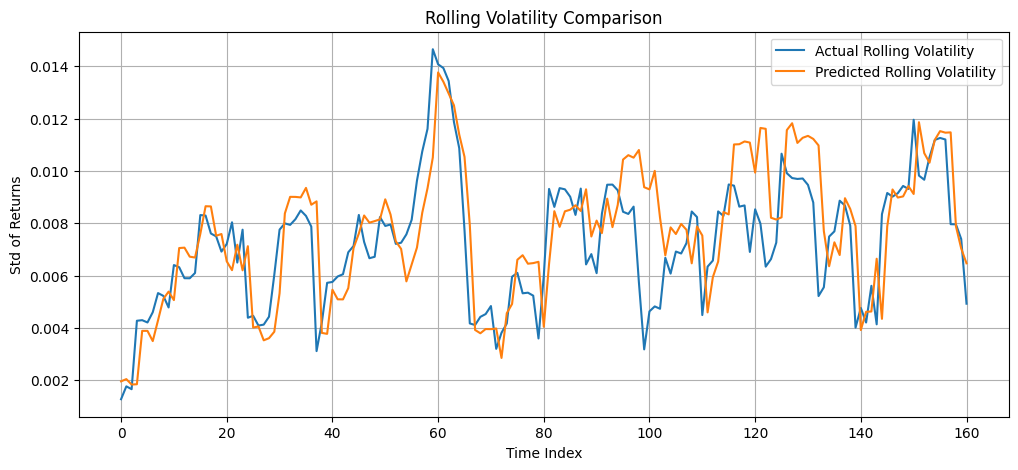

In [22]:
# Evaluate on test set
ko_model.eval()
preds, targets = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        pred = ko_model(xb).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
ko_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
ko_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(ko_targets_unscaled, ko_preds_unscaled))
mae = mean_absolute_error(ko_targets_unscaled, ko_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(ko_targets_unscaled, label="Actual")
plt.plot(ko_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(ko_targets_unscaled) / ko_targets_unscaled[:-1]
pred_returns   = np.diff(ko_preds_unscaled) / ko_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()
